# **INITIALIZATION**

In [1]:
# importing libraries
import pandas as pd
import numpy as nd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from tabulate import tabulate
from IPython.display import display, Image, Markdown
from difflib import get_close_matches
plt.ioff()

# seaborn parameters
sns.set(style="whitegrid", context="paper", rc={"axes.titlesize": 14, "axes.labelsize": 12,
    "xtick.labelsize": 12, "ytick.labelsize": 12})

# URL to get raw CSV data from GitHub
url = "https://raw.githubusercontent.com/ayushinto-space/Performance-Metrics-and-Sales-Analysis-Using-Python/main/Sales_Dataset_Uncleaned.csv"
df_unclean = pd.read_csv(url)
df_unclean.head()

,Order ID,Order Date,Customer Name,Region,City,Category,Sub-Category,Product Name,Quantity,Unit Price,Discount,Sales,Profit,Payment Mode
0,10001,2024-10-19,Kashvi Varty,South,Bangalore,Books,Non-Fiction,Non-Fiction Ipsum,2,36294,5,68958.6,10525.09,Debit Card
1,10002,2025-08-30,Advik Desai,North,Delhi,Groceries,Rice,Rice Nemo,1,42165,20,33732.0,6299.66,Debit Card
2,10003,2023-11-04,Rhea Kalla,East,Patna,Kitchen,Juicer,Juicer Odio,4,64876,20,207603.2,19850.27,Credit Card
3,10004,2025-05-23,Anika Sen,East,Kolkata,Groceries,Oil,Oil Doloribus,5,37320,15,158610.0,36311.02,UPI
4,10005,2025-01-19,Akarsh Kaul,West,Pune,Clothing,Kids Wear,Kids Wear Quo,1,50037,10,45033.3,9050.04,Debit Card


# **DATA CLEANING**

In [2]:
# data uniformity
df_unclean.columns = df_unclean.columns.str.strip().str.lower().str.replace(" ", "_")
df_unclean.drop_duplicates(inplace=True)

num_cols = ['quantity', 'unit_price', 'discount', 'sales', 'profit']
df_unclean['order_date'] = pd.to_datetime(df_unclean['order_date'], errors='coerce')
df_unclean[num_cols] = df_unclean[num_cols].apply(pd.to_numeric, errors='coerce')

# missing value handles
# for numeric values replaced with median
for col in num_cols:
    df_unclean[col] = df_unclean[col].fillna(df_unclean[col].median())

# for string values replaced with unknown
cat_cols = ['customer_name','region','city','category','sub-category',
            'product_name','payment_mode']
for col in cat_cols:
    df_unclean[col] = df_unclean[col].fillna('Unknown')

# data uniformity
df_unclean['profit_margin'] = (df_unclean['profit'] / df_unclean['sales'])*100
df_unclean['category'] = df_unclean['category'].str.title()
df_unclean['sub-category'] = df_unclean['sub-category'].str.title()
df_unclean['city'] = df_unclean['city'].str.title()
df_unclean['region'] = df_unclean['region'].str.title()
df_unclean['payment_mode'] = df_unclean['payment_mode'].str.title()
df_unclean['order_month_name'] = df_unclean['order_date'].dt.month_name()
df_unclean['order_month_num'] = df_unclean['order_date'].dt.month

# data outliners
# clipping outliners to 99%ile of dataset
q99 = df_unclean['quantity'].quantile(0.99)
df_unclean['quantity'] = df_unclean['quantity'].clip(upper=q99)
p99 = df_unclean['unit_price'].quantile(0.99)
df_unclean['unit_price'] = df_unclean['unit_price'].clip(upper=p99)

# save
df_unclean.to_csv("Sales_Cleaned.csv", index=False)
files.download("Sales_Cleaned.csv")

print(df_unclean.info())
print(df_unclean.isna().sum())
df_unclean.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   order_id          5000 non-null   int64         
 1   order_date        5000 non-null   datetime64[ns]
 2   customer_name     5000 non-null   object        
 3   region            5000 non-null   object        
 4   city              5000 non-null   object        
 5   category          5000 non-null   object        
 6   sub-category      5000 non-null   object        
 7   product_name      5000 non-null   object        
 8   quantity          5000 non-null   int64         
 9   unit_price        5000 non-null   float64       
 10  discount          5000 non-null   int64         
 11  sales             5000 non-null   float64       
 12  profit            5000 non-null   float64       
 13  payment_mode      5000 non-null   object        
 14  profit_margin     5000 n

,order_id,order_date,customer_name,region,city,category,sub-category,product_name,quantity,unit_price,discount,sales,profit,payment_mode,profit_margin,order_month_name,order_month_num
0,10001,2024-10-19,Kashvi Varty,South,Bangalore,Books,Non-Fiction,Non-Fiction Ipsum,2,36294.0,5,68958.6,10525.09,Debit Card,15.262911,October,10
1,10002,2025-08-30,Advik Desai,North,Delhi,Groceries,Rice,Rice Nemo,1,42165.0,20,33732.0,6299.66,Debit Card,18.675620,August,8
2,10003,2023-11-04,Rhea Kalla,East,Patna,Kitchen,Juicer,Juicer Odio,4,64876.0,20,207603.2,19850.27,Credit Card,9.561640,November,11
3,10004,2025-05-23,Anika Sen,East,Kolkata,Groceries,Oil,Oil Doloribus,5,37320.0,15,158610.0,36311.02,Upi,22.893273,May,5
4,10005,2025-01-19,Akarsh Kaul,West,Pune,Clothing,Kids Wear,Kids Wear Quo,1,50037.0,10,45033.3,9050.04,Debit Card,20.096329,January,1


# **EXPLORATION FUNCTIONS**

## **KPI**

In [9]:
# loyalty matrix
def customer_loyalty(df_clean):
    loyalty_matrix = (df_clean.groupby(['customer_name', 'order_month']).size().unstack(fill_value=0))

    top_customers = (df_clean.groupby('customer_name').size().sort_values(ascending=False).head(15).index)
    loyalty_matrix = loyalty_matrix.loc[top_customers]
    return loyalty_matrix

## **TIME-BASED FUNCTIONS**

In [3]:
# sales by year
def sales_by_year(df_clean):
    df_copy = df_clean.copy()
    df_copy["year"] = df_copy["order_date"].dt.year
    return df_copy.groupby("year")["sales"].sum()

# profit margin by year
def profit_margin_by_year(df_clean):
    df_copy = df_clean.copy()
    df_copy["year"] = df_copy["order_date"].dt.year
    yearly = df_copy.groupby("year")[["sales", "profit"]].sum()
    yearly["profit_margin"] = yearly["profit"] / yearly["sales"]
    return yearly["profit_margin"]

# sales by month
def sales_by_month(df_clean):
    df_clean = df_clean.copy()
    df_clean['month'] = df_clean['order_date'].dt.to_period('M')
    monthly = df_clean.groupby('month')['profit'].sum()
    return monthly

## **REGION-BASED FUNCTIONS**

In [4]:
# top cities
def top_cities(df, top = 10):
    df_copy = df.copy()
    city_data = df_copy.groupby('city')[['sales','profit']].sum()
    city_data = city_data.sort_values('sales', ascending=False).head(top)
    return city_data

# **EXPLORATION**

/tmp/ipython-input-2593378540.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=yearly_sales.index, y=yearly_sales.values, palette="PuBuGn", hue=None, legend=False)


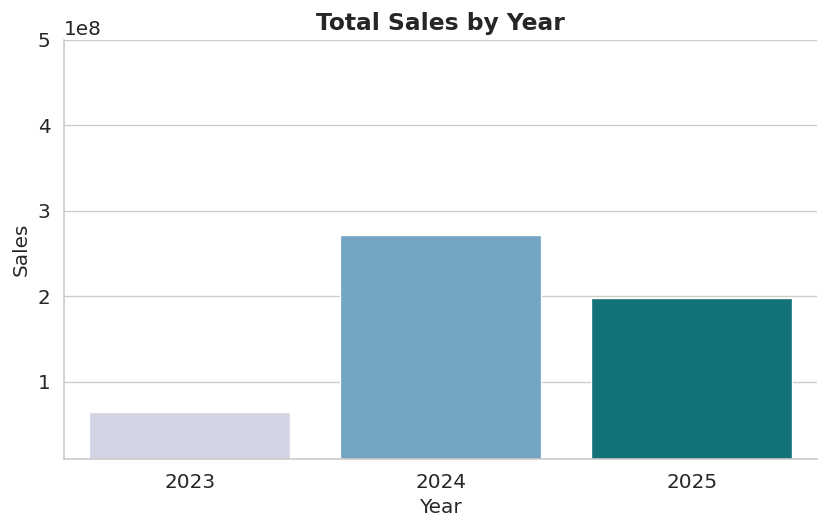

### INSIGHT
---

The graph shows a clear sales trend over three years. In **2023, sales are relatively low, indicating an early growth** or development stage with limited market reach or brand presence. A **sharp increase in 2024** reflects strong performance, likely due to successful marketing, market expansion, or improved sales strategies. In **2025, sales decline** compared to 2024 but remain well above 2023 levels, suggesting a **normal market correction rather than a major downturn**. Overall, the trend highlights **strong growth potential** while emphasizing the need for sustainable strategies such as customer retention, operational efficiency, and **continuous innovation to maintain long-term stability**.


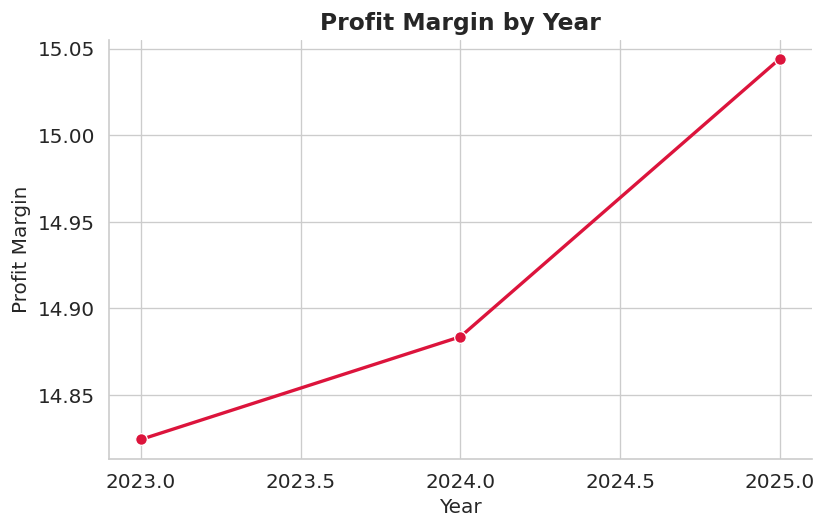

### INSIGHT
---

The graph shows a gradual and **consistent improvement in profit margin** from 2023 to 2025. In 2023, the profit margin is at its lowest level, indicating relatively higher costs or lower pricing efficiency during that year. A slight **increase is observed in 2024**, suggesting better cost control, **improved pricing strategies, or operational efficiencies** despite changes in sales volume. By 2025, the profit margin rises more noticeably, reaching its highest point, which indicates that the company has **become more efficient in converting sales into profit**. Overall, this trend suggests improving profitability over time, likely driven by cost optimization, better resource management, and a focus on higher-margin products or services.



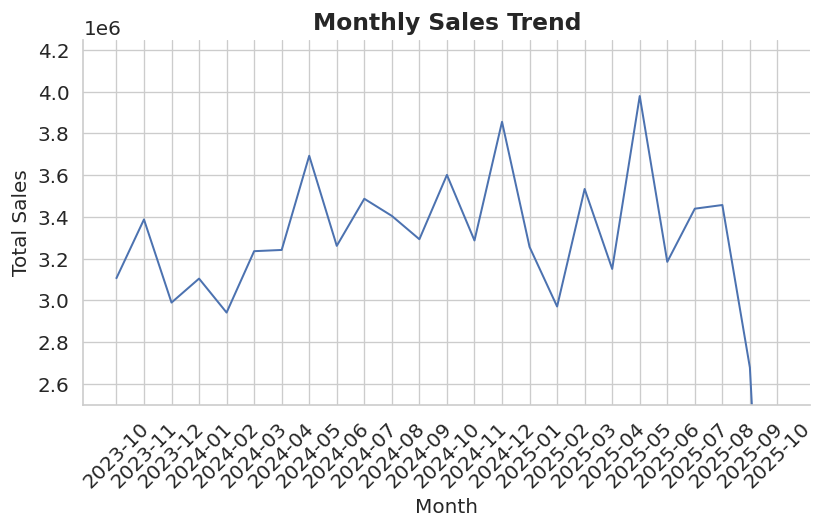

### INSIGHT
---

The monthly sales trend shows **noticeable fluctuations over time, indicating seasonal** and short-term variations in performance. From late 2023 through most of 2024, sales remain relatively stable with moderate ups and downs, suggesting **consistent demand** with periodic increases likely **due to promotions, seasonal effects, or higher customer activity**. Peaks observed at certain months reflect stronger sales periods, possibly during festive seasons or **successful marketing campaigns**. Moving into 2025, sales continue to fluctuate but generally stay within a similar range until a sharp decline appears in the final month. This sudden drop may be due to incomplete data for that month, operational disruptions, or an exceptional external factor. Overall, the trend suggests **stable monthly performance with predictable variability**, highlighting the importance of planning for seasonality and **investigating abrupt declines to prevent future revenue losses.**




/tmp/ipython-input-2593378540.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=city_data.index, y=city_data['sales'], palette='coolwarm')


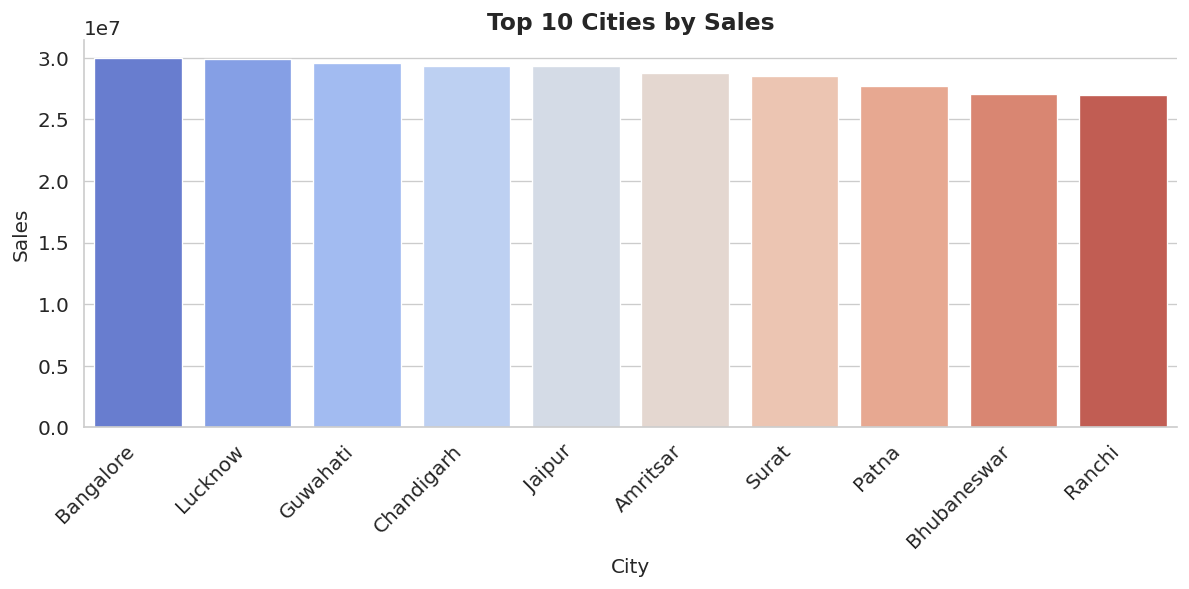

## INSIGHT
---

The bar chart highlights the top 10 cities by total sales, showing that sales are **relatively well distributed** among these major markets with no extreme outliers. Bangalore and Lucknow lead in sales, indicating **strong demand, better market penetration, or higher customer density in these cities.** Guwahati, Chandigarh, and Jaipur follow closely, suggesting consistent performance across multiple regions. Cities like Amritsar, Surat, Patna, Bhubaneswar, and Ranchi show slightly lower but still substantial sales figures, reflecting stable contributions to overall revenue. Overall, the chart suggests that while a **few cities perform marginally better**, the company has a **diversified urban sales base, reducing dependence on a single location** and offering opportunities to further strengthen performance in mid-ranking cities through targeted regional strategies.



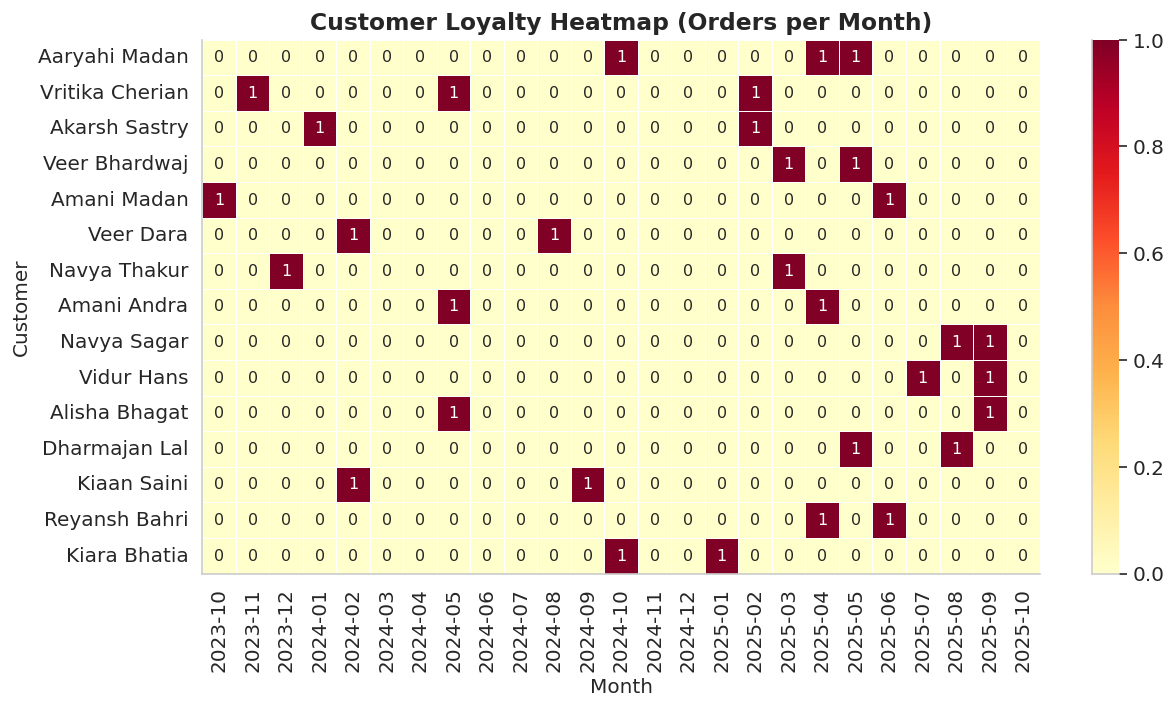

### INSIGHT
---

The customer loyalty heatmap shows that most customers place orders in **only one or two isolated months**, indicating a predominantly **low repeat-purchase behavior**. Only a few customers show orders spread across multiple months, suggesting the presence of a **small group of repeat or loyal customers**, but not strong long-term consistency. The absence of continuous dark patterns across consecutive months implies that customer engagement is **sporadic rather than sustained**. This trend suggests that while customers are willing to purchase, they are not being effectively retained over time. To improve loyalty, the business should focus on **customer retention strategies** such as follow-up communication, loyalty programs, personalized offers, and post-purchase engagement to encourage repeat orders and build long-term customer relationships.


In [15]:
url = "https://raw.githubusercontent.com/ayushinto-space/Performance-Metrics-and-Sales-Analysis-Using-Python/main/Sales_Cleaned.csv"
df_clean = pd.read_csv(url)
df_clean['order_date'] = pd.to_datetime(df_clean['order_date'])

df_clean.head()

# plot sales by year
def plot_sales_by_year(df_clean):
    yearly_sales = sales_by_year(df_clean)

    plt.figure(figsize=(7, 4.5), dpi=120)
    sns.barplot(x=yearly_sales.index, y=yearly_sales.values, palette="PuBuGn", hue=None, legend=False)

    plt.title("Total Sales by Year", fontweight="bold")
    plt.xlabel("Year")
    plt.ylabel("Sales")

    plt.ylim(1e7, 5e8)

    sns.despine()
    plt.tight_layout()
    fig = plt.gcf()
    plt.show()
    plt.close(fig)

    display(Markdown("""### INSIGHT
---

The graph shows a clear sales trend over three years. In **2023, sales are relatively low, indicating an early growth** or development stage with limited market reach or brand presence. A **sharp increase in 2024** reflects strong performance, likely due to successful marketing, market expansion, or improved sales strategies. In **2025, sales decline** compared to 2024 but remain well above 2023 levels, suggesting a **normal market correction rather than a major downturn**. Overall, the trend highlights **strong growth potential** while emphasizing the need for sustainable strategies such as customer retention, operational efficiency, and **continuous innovation to maintain long-term stability**.
"""))


# plot profit margin by year
def plot_profit_margin_by_year(df_clean):
    yearly_margin = profit_margin_by_year(df_clean)
    plt.figure(figsize=(7, 4.5), dpi=120)
    sns.lineplot(x=yearly_margin.index, y=yearly_margin.values*100, marker='o', linewidth=2,
        markersize=7, color="crimson")

    plt.title("Profit Margin by Year", fontweight="bold")
    plt.xlabel("Year")
    plt.ylabel("Profit Margin")

    plt.xticks([2023, 2023.5, 2024, 2024.5, 2025])

    sns.despine()
    plt.tight_layout()
    fig = plt.gcf()
    plt.show()
    plt.close(fig)

    display(Markdown("""### INSIGHT
---

The graph shows a gradual and **consistent improvement in profit margin** from 2023 to 2025. In 2023, the profit margin is at its lowest level, indicating relatively higher costs or lower pricing efficiency during that year. A slight **increase is observed in 2024**, suggesting better cost control, **improved pricing strategies, or operational efficiencies** despite changes in sales volume. By 2025, the profit margin rises more noticeably, reaching its highest point, which indicates that the company has **become more efficient in converting sales into profit**. Overall, this trend suggests improving profitability over time, likely driven by cost optimization, better resource management, and a focus on higher-margin products or services.

"""))

# plot sales by month
def plot_sales_by_month(df_clean):
    monthly = sales_by_month(df_clean)
    plt.figure(figsize=(7, 4.5), dpi=120)
    plt.plot(monthly.index.astype(str), monthly.values)
    plt.xticks(rotation=45)
    plt.title("Monthly Sales Trend", fontweight="bold")
    plt.xlabel("Month")
    plt.ylabel("Total Sales")
    sns.despine()
    plt.tight_layout()
    plt.ylim((2.5e6, 4.25e6))
    fig = plt.gcf()
    plt.show()
    plt.close(fig)

    display(Markdown("""### INSIGHT
---

The monthly sales trend shows **noticeable fluctuations over time, indicating seasonal** and short-term variations in performance. From late 2023 through most of 2024, sales remain relatively stable with moderate ups and downs, suggesting **consistent demand** with periodic increases likely **due to promotions, seasonal effects, or higher customer activity**. Peaks observed at certain months reflect stronger sales periods, possibly during festive seasons or **successful marketing campaigns**. Moving into 2025, sales continue to fluctuate but generally stay within a similar range until a sharp decline appears in the final month. This sudden drop may be due to incomplete data for that month, operational disruptions, or an exceptional external factor. Overall, the trend suggests **stable monthly performance with predictable variability**, highlighting the importance of planning for seasonality and **investigating abrupt declines to prevent future revenue losses.**


"""))

# plot top cities
def plot_top_cities(df, top =10):
    city_data = top_cities(df, top)
    plt.figure(figsize=(10,5), dpi = 120)
    sns.barplot(x=city_data.index, y=city_data['sales'], palette='coolwarm')
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Top {top} Cities by Sales", fontweight="bold")
    plt.xlabel("City")
    plt.ylabel("Sales")
    sns.despine()
    plt.tight_layout()
    fig = plt.gcf()
    plt.show()
    plt.close(fig)

    display(Markdown("""## INSIGHT
---

The bar chart highlights the top 10 cities by total sales, showing that sales are **relatively well distributed** among these major markets with no extreme outliers. Bangalore and Lucknow lead in sales, indicating **strong demand, better market penetration, or higher customer density in these cities.** Guwahati, Chandigarh, and Jaipur follow closely, suggesting consistent performance across multiple regions. Cities like Amritsar, Surat, Patna, Bhubaneswar, and Ranchi show slightly lower but still substantial sales figures, reflecting stable contributions to overall revenue. Overall, the chart suggests that while a **few cities perform marginally better**, the company has a **diversified urban sales base, reducing dependence on a single location** and offering opportunities to further strengthen performance in mid-ranking cities through targeted regional strategies.

"""))

# customer loyalty heat map
df_clean['order_month'] = df_clean['order_date'].dt.to_period('M').astype(str)
def plot_customer_loyalty(df_clean):
    loyalty_matrix = customer_loyalty(df_clean)
    plt.figure(figsize=(10.6, 6), dpi = 120)

    sns.heatmap(loyalty_matrix, cmap="YlOrRd", linewidths=0.5, annot=True, fmt="d")

    plt.title("Customer Loyalty Heatmap (Orders per Month)", fontweight="bold")
    plt.xlabel("Month")
    plt.ylabel("Customer")
    sns.despine()
    plt.tight_layout()
    fig = plt.gcf()
    plt.show()
    plt.close(fig)

    display(Markdown("""### INSIGHT
---

The customer loyalty heatmap shows that most customers place orders in **only one or two isolated months**, indicating a predominantly **low repeat-purchase behavior**. Only a few customers show orders spread across multiple months, suggesting the presence of a **small group of repeat or loyal customers**, but not strong long-term consistency. The absence of continuous dark patterns across consecutive months implies that customer engagement is **sporadic rather than sustained**. This trend suggests that while customers are willing to purchase, they are not being effectively retained over time. To improve loyalty, the business should focus on **customer retention strategies** such as follow-up communication, loyalty programs, personalized offers, and post-purchase engagement to encourage repeat orders and build long-term customer relationships.
"""))

# calling all plot functions
plot_sales_by_year(df_clean,)
plot_profit_margin_by_year(df_clean)
plot_sales_by_month(df_clean)
plot_top_cities(df_clean)
plot_customer_loyalty(df_clean)

# **INTERACTIVE ENVIRONMENT**

In [18]:
# defination functions
def calculate_sales(unit_price, quantity, discount):
    return unit_price * quantity * (1 - discount)

def calculate_profit(sales):
    return sales * 0.15  # % share of sales used as COGS price is not available

def calculate_profit_margin(sales, profit):
    return (profit / sales) * 100 if sales != 0 else 0

def update_month_columns(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    df['order_month_name'] = df['order_date'].dt.month_name()
    df['order_month_num'] = df['order_date'].dt.month
    return df

def save_csv(df):
    df.to_csv("updated_sales_data.csv", index=False)
    print("\nSaved as updated_sales_data.csv\n")

# menu functions
def search_record(df_edit):
    print("\n---- Search Customer ----")
    print("1. by Order ID")
    print("2. by Customer Name (fuzzy)")
    print("3. Exit")

    choice = input("\nEnter choice: ")

    if choice == "1":
        try:
          order_id = int(input("\nEnter Order ID to search: ").strip())
        except ValueError:
          print("Invalid input! Please enter a numeric Order ID.\n")
          return df_edit # Return df_edit on invalid input

        # check if order exists
        if order_id not in df_edit['order_id'].values:
            print("Order ID not found!\n")
            return df_edit # Return df_edit if order not found

        # get the matching row
        row = df_edit[df_edit['order_id'] == order_id]

        print("\nRecord Found:\n")
        print(tabulate(row, headers="keys", tablefmt="psql"))

        return df_edit  # returns the full df_edit to maintain state
    elif choice == "2":
        name_input = input("\nEnter customer name to search: ").strip()

        customer_names = df_edit['customer_name'].dropna().unique().tolist()

        # fuzzy pass
        matches = get_close_matches(name_input, customer_names, n=999,
        cutoff=0.5)   # lower = more tolerant

        if not matches:
          print("No similar customer names found!\n")
          return df_edit

        # if only one match, use it directly
        if len(matches) == 1:
          selected_name = matches[0]
        else:
          # show numbered menu
          print("\nMultiple matches found:")
          for i, name in enumerate(matches, start=1):
              print(f"{i}. {name}")
          # let user choose
          while True:
              choice = input(f"Select the correct customer (1-{len(matches)}): ").strip()
              if choice.isdigit() and 1 <= int(choice) <= len(matches):
                  selected_name = matches[int(choice)-1]
                  break
              print("Invalid choice, try again.")

        # filter rows for the selected customer
        result = df_edit[df_edit['customer_name'] == selected_name]

        print(f"\nRecords for customer: {selected_name}\n")
        print(tabulate(result, headers="keys", tablefmt="psql"))

        return df_edit
    elif choice == "3":
        print("\nExiting search...")
        return df_edit
    else:
        print("Invalid choice. Try again.")
        return df_edit # Added to ensure df_edit is always returned

# adding rows to dataset
def add_new_record(df_edit):
    print("\nEnter New Record Details:")
    new_row = {}
    new_row['order_id'] = input("Order ID: ")
    new_row['order_date'] = input("Order Date (YYYY-MM-DD): ")
    new_row['customer_name'] = input("Customer Name: ")
    new_row['region'] = input("Region: ")
    new_row['city'] = input("City: ")
    new_row['category'] = input("Category: ")
    new_row['subcategory'] = input("Subcategory: ")
    new_row['product_name'] = input("Product Name: ")
    new_row['quantity'] = int(input("Quantity: "))
    new_row['unit_price'] = float(input("Unit Price: "))
    new_row['discount'] = float(input("Discount (0-1): "))

    new_row['sales'] = calculate_sales(new_row['unit_price'], new_row['quantity'], new_row['discount'])
    new_row['profit'] = calculate_profit(new_row['sales'])
    new_row['payment_mode'] = input("Payment Mode: ")
    new_row['profit_margin'] = calculate_profit_margin(new_row['sales'], new_row['profit'])

    df_edit.loc[len(df_edit)] = new_row
    df_edit = update_month_columns(df_edit)
    save_csv(df_edit)
    df_edit = pd.read_csv("updated_sales_data.csv")
    print("\nRecord Added Successfully! New rows:\n")
    print(tabulate(df_edit.tail(5), headers="keys", tablefmt="psql"))
    return df_edit

# modifying rows to dataset
def modify_record(df_edit):
    order_id = int(input("\nEnter Order ID to modify: "))
    try:
        order_id = int(order_id)
    except ValueError:
        print("Invalid Order ID format. Please enter a number.\n")
        return df_edit

    if order_id not in df_edit['order_id'].values:
        print("Order ID not found!\n")
        return df_edit

    row_index = df_edit[df_edit['order_id'] == order_id].index[0]

    print("\nColumns you can modify:")
    print(df_edit.columns.tolist())
    col = input("Column name to modify: ")

    if col not in df_edit.columns:
        print("Invalid column!\n")
        return df_edit

    new_value = input("Enter new value: ")

    # Convert numeric fields
    if col in ['quantity', 'order_month_num']:
        try:
            new_value = int(new_value)
        except ValueError:
            print(f"Invalid input for {col}. Please enter an integer.\n")
            return df_edit
    elif col in ['unit_price', 'discount', 'sales', 'profit', 'profit_margin']:
        try:
            new_value = float(new_value)
        except ValueError:
            print(f"Invalid input for {col}. Please enter a number.\n")
            return df_edit
    elif col == 'order_date':
        try:
            new_value = pd.to_datetime(new_value)
        except ValueError:
            print(f"Invalid input for {col}. Please enter date in YYYY-MM-DD format.\n")
            return df_edit

    df_edit.at[row_index, col] = new_value

    # Recalculate dependent fields if needed
    if col in ['order_date', 'quantity', 'unit_price', 'discount', 'profit']:
        r = df_edit.loc[row_index]
        df_edit.at[row_index, 'sales'] = calculate_sales(r['unit_price'], r['quantity'], r['discount'])
        df_edit.at[row_index, 'profit'] = calculate_profit(df_edit.at[row_index, 'sales']) # Recalculate profit if sales changes
        df_edit.at[row_index, 'profit_margin'] = calculate_profit_margin(df_edit.at[row_index, 'sales'], df_edit.at[row_index, 'profit'])
        df_edit = update_month_columns(df_edit)
    save_csv(df_edit)
    print("\nRecord Modified! Updated row:\n")
    print(tabulate(df_edit.loc[[row_index]], headers="keys", tablefmt="psql"))
    return df_edit

# deletion of rows from dataset
def delete_record(df_edit):
    order_id = input("\nEnter Order ID to delete: ")
    try:
        order_id = int(order_id)
    except ValueError:
        print("Invalid Order ID format. Please enter a number.\n")
        return df_edit

    if order_id not in df_edit['order_id'].values:
        print("Order ID not found!\n")
        return df_edit

    df_edit = df_edit[df_edit['order_id'] != order_id].reset_index(drop=True)
    save_csv(df_edit)
    df_edit = pd.read_csv("updated_sales_data.csv")
    print("\nRecord Deleted! Latest rows:\n")
    print(tabulate(df_edit.tail(5), headers="keys", tablefmt="psql"))
    return df_edit

# satistical function explorer
def statisics_record(df_edit):
    print("\n---- Statistical Analysis ----")
    print("1. Sales by Year")
    print("2. Profit Margin by Year")
    print("3. Sales by Month")
    print("4. Top City Sales")
    print("5. Customer Loyalty Matrix")
    print("6. Exit")
    choice = input("\nEnter choice: ")

    if choice == "1":
        plot_sales_by_year(df_edit)
        return df_edit
    elif choice == "2":
        plot_profit_margin_by_year(df_edit)
        return df_edit
    elif choice == "3":
        plot_sales_by_month(df_edit)
        return df_edit
    elif choice == "4":

        try:
            top = int(input("Enter the number of top cities to display: "))
        except ValueError:
            print("Invalid input, using default top 10.")
            top = 10

        fig = plt.gcf() # This line is not needed here as plot_top_cities handles it
        plot_top_cities(df_edit, top)
        plt.show() # plot_top_cities already shows the plot
        plt.close(fig) # plot_top_cities already closes the figure
        return df_edit
    elif choice == "5":
        fig = plt.gcf() # This line is not needed here as plot_top_cities handles it
        plot_customer_loyalty(df_edit)
        plt.show() # plot_top_cities already shows the plot
        plt.close(fig) # plot_top_cities already closes the figure
        return df_edit
    elif choice == "6":
        print("\nExiting statistical analysis...")
        return df_edit
    else:
        print("Invalid choice. Try again.")
        return df_edit

# database showcase
def show_dataset(df_edit):
    print("\n---- Edited Dataset Preview ----")
    print(tabulate(df_edit.head(10), headers="keys", tablefmt="psql"))

# menu editor
def menu_based_data_editor(df_clean):
    df_edit = df_clean.copy()  # work on copy

    while True:
        print("\n------------ MENU ------------")
        print("1. Add new record")
        print("2. Modify a record by Order ID")
        print("3. Delete a record by Order ID")
        print("4. Show dataset preview")
        print("5. Satistics ")
        print("6. Search Customer")
        print("7. Exit")
        choice = input("\nEnter choice: ")

        match choice:
            case "1":
                df_edit = add_new_record(df_edit)
            case "2":
                df_edit = modify_record(df_edit)
            case "3":
                df_edit = delete_record(df_edit)
            case "4":
                show_dataset(df_edit)
            case "5":
                df_edit = statisics_record(df_edit)
                pass
            case "6":
                df_edit = search_record(df_edit)
            case "7":
                print("\nExiting menu...")
                return df_edit
            case _:
                print("Invalid choice. Try again.")

# menu viewer
if __name__ == "__main__":
    try:
        print("Dataset loaded successfully. Total rows:", len(df_clean))
    except FileNotFoundError:
        print("File not found! Please make sure 'sales_data.csv' exists.")
        exit()

    df_updated = menu_based_data_editor(df_clean)

    print("\nFinal Edited Dataset Preview:\n")
    print(tabulate(df_updated.tail(10), headers="keys", tablefmt="psql"))

Dataset loaded successfully. Total rows: 5000

------------ MENU ------------
1. Add new record
2. Modify a record by Order ID
3. Delete a record by Order ID
4. Show dataset preview
5. Satistics 
6. Search Customer
7. Exit

Enter choice: 1

Enter New Record Details:
Order ID: 15001
Order Date (YYYY-MM-DD): 2025-12-10
Customer Name: Ayush
Region: West
City: Pune
Category: Book
Subcategory: Fiction
Product Name: Harry
Quantity: 2
Unit Price: 750
Discount (0-1): 0.2
Payment Mode: Credit

Saved as updated_sales_data.csv


Record Added Successfully! New rows:

+------+------------+--------------+-------------------+----------+-----------+-------------+----------------+---------------------+------------+--------------+------------+----------+----------+----------------+-----------------+--------------------+-------------------+---------------+
|      |   order_id | order_date   | customer_name     | region   | city      | category    | sub-category   | product_name        |   quantity |   un

# **TEST**